In [1]:
import cv2 as cv
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

In [2]:
video = cv.VideoCapture("/Users/nadaelarabi/Data-driven-dynamical-systems/SlidingWindowDMD/catVideo.mp4")

frames = []
ret = True
while ret:
    ret,img = video.read()
    if ret:
        greyscale = np.mean(img,-1)
        frames.append(greyscale)
videoData = np.stack(frames,axis=0)
videoDataTranspose = videoData.T #Tjis is possibly unecessary?

widthVideo = videoDataTranspose.shape[0]
heightVideo = videoDataTranspose.shape[1]
numberPixelsPerFrame = widthVideo * heightVideo
numberOfFrames = videoDataTranspose.shape[2]

#Here we can reshape the data to have each frame represented as columns stacked
dataMat = (np.reshape(videoData,(numberOfFrames,numberPixelsPerFrame))).transpose()


In [3]:
dataMat.shape

(230400, 160)

In [4]:
#We create the Windows

#T refers to the size of each window
T = 60
numberOfWindows = numberOfFrames - T

#This matrix will contain the Windows
matrixWindows = []
for i in range(numberOfWindows):
    matrixWindows.append(dataMat[:,i:i+T])
matrixWindows = np.array(matrixWindows)

#Now we can make matrices to contain the values of the SVD decomposition
u_matrix = []
vt_matrix = []
sigma_matrix = []

#Here we calculate the SVD of each of the Windows 
for i in range(numberOfWindows):
    u,s,vt = np.linalg.svd(matrixWindows[i],full_matrices=False)
    u_matrix.append(u)
    vt_matrix.append(vt)
    sigma_matrix.append(s)

u_matrix = np.array(u_matrix)
vt_matrix = np.array(vt_matrix)
sigma_matrix = np.array(sigma_matrix)


In [5]:
u_matrix[0].shape

(230400, 60)

In [6]:
sigma_matrix[0][1]

63956.795120146046

In [7]:
#Now that we have the SVD for each Window, we can find the number of significant modes for each

#Question: do the DMD matrices A^k have to all be the same size? Why does the book say they would have N eigenvalues?
#Answer: They should preferrably be the same size to make analysis easier


significant_singularVal_Matrix = []
tau_matrix = []
nbRowsWindow = numberPixelsPerFrame
nbColumnsWindow = matrixWindows.shape[2]
beta = 1-(nbColumnsWindow/nbRowsWindow)
omega = 0.56*(beta*beta*beta) - 0.95*(beta*beta) + 1.82*beta + 1.43

for i in range(numberOfWindows):
    median = np.median(sigma_matrix[i])
    tau = omega * median
    tau_matrix.append(tau)
    counter = 0
    j =0
    while tau<sigma_matrix[i][j]:
        j += 1
        counter += 1
    significant_singularVal_Matrix.append(counter)



In [8]:
#We've only defined the tau matrix to do some manual verification

significant_singularVal_Matrix = np.array(significant_singularVal_Matrix)
tau_matrix = np.array(tau_matrix)

#Now we should determine how many significant values we should keep for all DMD matrices
#One approach would be to take the maximum:

nbSingularValues = np.max(significant_singularVal_Matrix)
nbSingularValues

#Now we can apply the DMD algorithm to every window

#Here we reduce our u_matrix depending on the selected number of singular values
u_reduced = []
for i in range(numberOfWindows):
    u_reduced.append(u_matrix[i][:,0:nbSingularValues])
u_reduced = np.array(u_reduced)

In [41]:
u_matrix[0].shape

(230400, 60)

In [11]:
u_reduced[0].shape

(230400, 22)

In [13]:
matrixWindows[0].shape

(230400, 60)

In [9]:
#Now let's reduce our data
data_reduced = []
for i in range(numberOfWindows):
    data_reduced.append(np.matmul(u_reduced[i].T,matrixWindows[i]))
data_reduced = np.array(data_reduced)

In [10]:
#Now we can create our X and Y matrices 
n = data_reduced[0].shape[1]
X_matrix = []
Y_matrix = []
for i in range(numberOfWindows):
    X_matrix.append(data_reduced[i][:,0:n-1])
    Y_matrix.append(data_reduced[i][:,1:n])
X_matrix = np.array(X_matrix)
Y_matrix = np.array(Y_matrix)

In [11]:
#Now we can calculate the transpose of each X:
Xt_matrix = []
for i in range(numberOfWindows):
    Xt_matrix.append(np.linalg.pinv(X_matrix[i]))
Xt_matrix = np.array(Xt_matrix)

#We proceed to finding the DMD matrices
DMD_matrices = []
for i in range(numberOfWindows):
    DMD_matrices.append(np.matmul(Y_matrix[i],Xt_matrix[i]))
DMD_matrices = np.array(DMD_matrices)

In [38]:
DMD_matrices.shape

(100, 22, 22)

In [32]:
X_matrix[i].shape

(22, 59)

In [25]:
X.shape

(100, 22, 60)

In [12]:
#Now we can extract all eigenvalues and eigenvectors from the DMD matrices
eigenvalues_matrix = []
eigenvector_matrix = []
for i in range(numberOfWindows):
    eigenvalues, eigenvectors = np.linalg.eig(DMD_matrices[i])
    eigenvalues_matrix.append(eigenvalues)
    eigenvector_matrix.append(eigenvectors)
eigenvalues_matrix = np.array(eigenvalues_matrix)
eigenvector_matrix = np.array(eigenvector_matrix)

In [43]:
eigenvector_matrix.shape

(100, 22, 22)

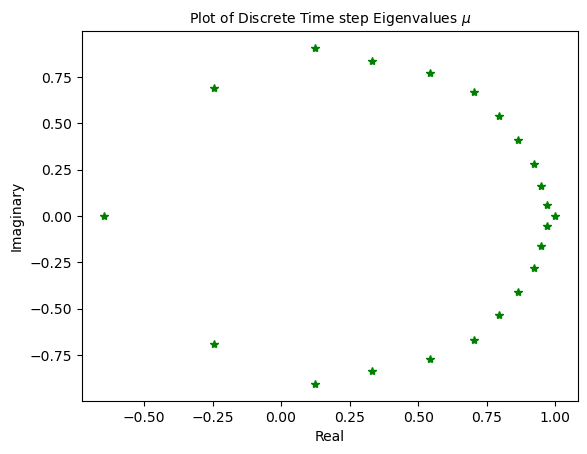

In [13]:
reals = eigenvalues_matrix[80].real
imagin = eigenvalues_matrix[80].imag
plt.plot(reals,imagin,'g*') #where I divided by 6/379
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title("Plot of Discrete Time step Eigenvalues $\mu$",fontsize=10)
plt.show()

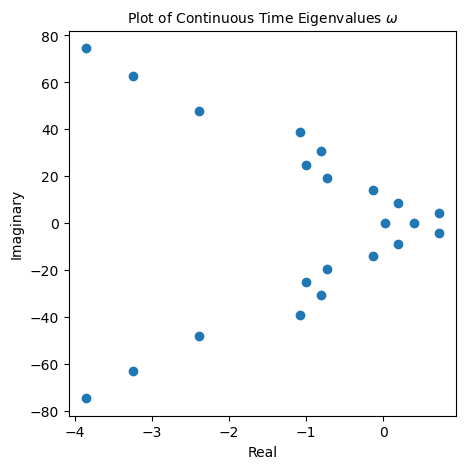

In [14]:
omega = [] # set of transformed eigenvalues 
dt =6/numberOfFrames

for i in range(numberOfWindows):
    omega_log = np.log(eigenvalues_matrix[i])/dt
    omega.append(omega_log)
omega = np.array(omega)

# for eigenvalue in eigenvalues:
#   omegak = np.log(eigenvalue)/dt
#   omega.append(omegak)

# omega = np.array(omega)


# We can plot the continuous time eigenvalues 
plt.figure(figsize=(5,5))
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Plot of Continuous Time Eigenvalues $\omega$",fontsize=10)
plt.scatter((omega[5]).real,(omega[5]).imag)

In [15]:
#Let's try and see if we get a proper separation

#First let's take the absolute value of all eigenvalues and square them 

for i in range(numberOfWindows):
    omega[i] = np.absolute(omega[i])
    omega[i] = np.square(omega[i])

#Now we concatenate all eigenvalues in a single vector
array_nbColumns = numberOfWindows*omega[0].shape[0]
# concatenated_eigenvalues = np.zeros((1,array_nbColumns))
# position = 0
# for i in range(numberOfWindows):
#     concatenated_eigenvalues[:,position:i+nbSingularValues] = omega[i]
#     position = i*nbSingularValues

#Maybe just reshape the omega vector

concatenated_eigenvalues = np.reshape(omega,(array_nbColumns,1))

array([[7040.97012566+0.j, 4904.05343359+0.j, 4904.05343359+0.j, ...,
          10.23791397+0.j,   33.01748157+0.j,   33.01748157+0.j],
       [7028.84011905+0.j, 4979.89028825+0.j, 4979.89028825+0.j, ...,
         215.38821945+0.j,  399.38892253+0.j,  399.38892253+0.j],
       [7031.54261058+0.j, 4921.91218658+0.j, 4921.91218658+0.j, ...,
         204.41886606+0.j,  353.84996097+0.j,  353.84996097+0.j],
       ...,
       [7047.21556248+0.j, 4440.63290992+0.j, 4440.63290992+0.j, ...,
          21.99372952+0.j,   68.58575945+0.j,   68.58575945+0.j],
       [5594.13629162+0.j, 5594.13629162+0.j, 4065.07074396+0.j, ...,
          19.30951108+0.j,   60.67294374+0.j,   60.67294374+0.j],
       [7048.22457146+0.j, 4045.49280879+0.j, 4045.49280879+0.j, ...,
          36.9585526 +0.j,  102.85034737+0.j,  102.85034737+0.j]])

In [109]:
concatenated_eigenvalues.shape

(1, 2200)

In [77]:
omega[0].shape[0]

22

In [91]:
array_nbColumns

2200

In [16]:
concatenated_eigenvalues

array([[7040.97012566+0.j],
       [4904.05343359+0.j],
       [4904.05343359+0.j],
       ...,
       [  36.9585526 +0.j],
       [ 102.85034737+0.j],
       [ 102.85034737+0.j]])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True]])

In [106]:
omega[0].shape

(22,)

In [115]:
x_axis = np.linspace(0,100,2200)

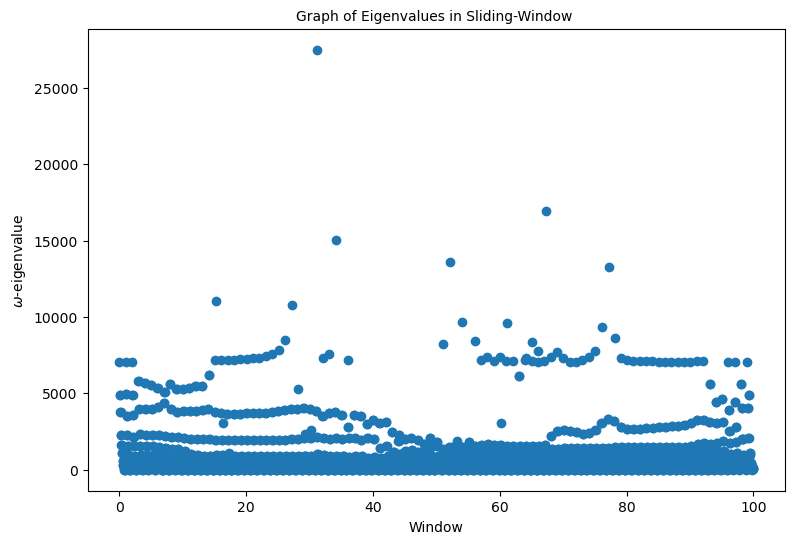

In [17]:
x_axis = np.linspace(0,100,2200)
plt.figure(figsize=(9,6))
plt.xlabel("Window")
plt.ylabel("$\omega$-eigenvalue")
plt.title("Graph of Eigenvalues in Sliding-Window ",fontsize=10)
plt.scatter(x_axis,concatenated_eigenvalues.real)

In [19]:
from sklearn.cluster import KMeans

In [20]:
concatenated_eigenvalues = np.real(concatenated_eigenvalues)
kmeans = KMeans(n_clusters=2, random_state=0).fit(concatenated_eigenvalues)
kmeans.cluster_centers_

array([[ 542.96939031],
       [5400.79655477]])